In [1]:
import sys
# sys.path.insert(0,'~/Repos/newcastle/air-quality/src')
sys.path.insert(0,'../src')
from v0 import *

import matplotlib.pylab as plt
import seaborn as sns

In [2]:
SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_30days/'
zx, zi = load_data__(DATA_FOLDER)
print('data loaded')

data loaded


In [3]:
zx, zi = resampling_sensors__(zx, zi, 'H')

In [4]:
print(zx.shape)
zx.head()

(54944, 47)


NO2  \
Sensor Name                                   Timestamp                        
Newcastle_Cradlewell_Roadside_AURN_AQ_MONITOR 2018-07-01 07:00:00  40.071259   
                                              2018-07-01 08:00:00  36.680398   
                                              2018-07-01 09:00:00  30.217993   
                                              2018-07-01 10:00:00  31.349283   
                                              2018-07-01 11:00:00  28.340342   

                                                                         NO2  \
Sensor Name                                   Timestamp                        
Newcastle_Cradlewell_Roadside_AURN_AQ_MONITOR 2018-07-01 07:00:00  52.761072   
                                              2018-07-01 08:00:00  52.662089   
                                              2018-07-01 09:00:00  52.115198   
                                              2018-07-01 10:00:00  47.794581   
                                              2018-07-01 11:00:00  45.193603   

                                                                         NO2  \
Sensor Name                                   Timestamp                        
Newcastle_Cradlewell_Roadside_AURN_AQ_MONITOR 2018-07-01 07:00:00  41.950413   
                                              2018-07-01 08:00:00  38.747833   
                                              2018-07-01 09:00:00  39.462704   
                                              2018-07-01 10:00:00  38.537461   
                                              2018-07-01 11:00:00  43.269422   

                                                                         NO2  \
Sensor Name                                   Timestamp                        
Newcastle_Cradlewell_Roadside_AURN_AQ_MONITOR 2018-07-01 07:00:00  10.974562   
                                              2018-07-01 08:00:00  19.596998   
                                              2018-07-01 09:00:00  20.002890   
                                              2018-07-01 10:00:00  28.878558   
                                              2018-07-01 11:00:00  30.169931   

                                                                         NO2  \
Sensor Name                                   Timestamp                        
Newcastle_Cradlewell_Roadside_AURN_AQ_MONITOR 2018-07-01 07:00:00  18.395864   
                                              2018-07-01 08:00:00  14.205561   
                                              2018-07-01 09:00:00   7.735414   
                                              2018-07-01 10:00:00   3.602518   
                                              2018-07-01 11:00:00   7.131518   

                                                                      d_NO2  \
Sensor Name                                   Timestamp                       
Newcastle_Cradlewell_Roadside_AURN_AQ_MONITOR 2018-07-01 07:00:00  0.004074   
                                              2018-07-01 08:00:00  0.004074   
                                              2018-07-01 09:00:00  0.004074   
                                              2018-07-01 10:00:00  0.004074   
                                              2018-07-01 11:00:00  0.004074   

                                                                      d_NO2  \
Sensor Name                                   Timestamp                       
Newcastle_Cradlewell_Roadside_AURN_AQ_MONITOR 2018-07-01 07:00:00  0.017249   
                                              2018-07-01 08:00:00  0.017249   
                                              2018-07-01 09:00:00  0.017036   
                                              2018-07-01 10:00:00  0.017036   
                                              2018-07-01 11:00:00  0.017036   

                                                                     d_NO2  \
Sensor Name                                   Timestamp                      
Newc

# 1. IDW

In [53]:
from sklearn.metrics import r2_score, mean_squared_error

print(r2_score(zi,iwd(zx, 'NO2', 1)))
print(r2_score(zi,iwd(zx, 'NO2', 2)))
print(r2_score(zi,iwd(zx, 'NO2', 3)))
print(r2_score(zi,iwd(zx, 'NO2', 4)))
print(r2_score(zi,iwd(zx, 'NO2', 5)))

-0.18052015468933114
-0.2671680037618993
-0.3177718494400308
-0.34701322480897767
-0.3663618005392306


# 2. Machine Learning based

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

## a. With secondary information (zxs) 

In [6]:
zxs = MinMaxScaler().fit_transform(zx)

## b. With only primary information (zxp)

In [104]:
zxp = MinMaxScaler().fit_transform(zx[['NO2','d_NO2']])

# 3. NeuralNet-based & others

In [38]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# 10-Fold Cross Validation (R2 and MSE)

In [8]:
# kfcv(k=10, model=GradientBoostingRegressor(n_estimators=200, max_depth=5, max_features=None),
#      X=zxt, y=np.log(zi['Value']))

gb = GradientBoostingRegressor(n_estimators=200, max_depth=5, max_features=None).fit(zxs,np.log(zi['Value']))

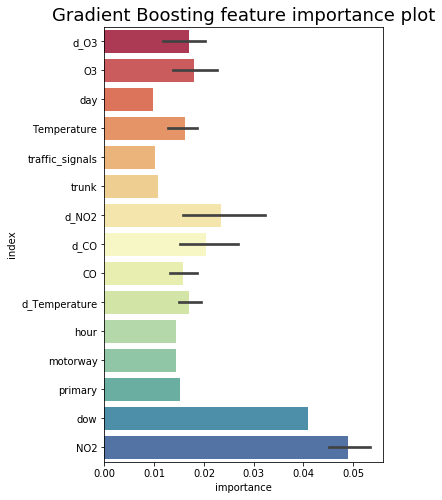

In [9]:
importances = gb.feature_importances_
indices = zx.columns[np.argsort(importances)[::-1]]
f = pd.DataFrame(importances, index=indices, columns=['importance']).reset_index().sort_values('importance')

plt.figure(figsize=(5,8))
plt.title('Gradient Boosting feature importance plot',fontsize=18)
sns.barplot(y='index',x='importance',data=f, palette='Spectral');

In [105]:
val = pd.DataFrame(index=['gb_s','rf_s','ab_s','gb_p','rf_p','ab_p'], columns=['r2','r2_std','mse','mse_std'])

val.loc['rf_s'] = kfcv(model=RandomForestRegressor(n_estimators=200, max_depth=5, max_features=0.5),
                     X=zxs, y=np.log(zi['Value']))
val.loc['gb_s'] = kfcv(model=GradientBoostingRegressor(n_estimators=200, max_depth=5, max_features=0.5),
                     X=zxs, y=np.log(zi['Value']))
val.loc['ab_s'] = kfcv(model=AdaBoostRegressor(n_estimators=200),
                     X=zxs, y=np.log(zi['Value']))

val.loc['rf_p'] = kfcv(model=RandomForestRegressor(n_estimators=200, max_depth=5, max_features=None),
                     X=zxp, y=np.log(zi['Value']))
val.loc['gb_p'] = kfcv(model=GradientBoostingRegressor(n_estimators=200, max_depth=5, max_features=None),
                     X=zxp, y=np.log(zi['Value']))
val.loc['ab_p'] = kfcv(model=AdaBoostRegressor(n_estimators=200),
                     X=zxp, y=np.log(zi['Value']))

val.to_csv(DATA_FOLDER+'10fcv_trees_200-5_#0.csv')